In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import auc,roc_auc_score,precision_score,recall_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler,SMOTE

In [2]:
train_data=pd.read_csv("heart_train.csv")
train_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [3]:
print ('Train Data Shape: {}'.format(train_data.shape))

Train Data Shape: (43400, 12)


#### Checking missing values

In [4]:
train_missing_values=train_data.isnull().sum()
train_missing_values

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

# Data preprocessing

#### Clean the missing values both training and testing data

In [5]:
train_data["bmi"]=train_data["bmi"].fillna(value=0)

#### Checking unique values in a dataset

In [6]:
train_data["stroke"].unique()

array([0, 1], dtype=int64)

In [7]:
train_data["smoking_status"].unique()

array([nan, 'never smoked', 'formerly smoked', 'smokes'], dtype=object)

In [8]:
train_data["ever_married"].unique()

array(['No', 'Yes'], dtype=object)

#### Finding the no.of patients affected by stroke

In [9]:
train_data["stroke"].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

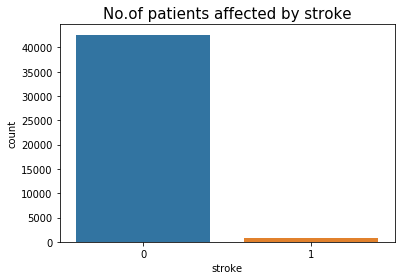

In [10]:
sns.countplot(x=train_data["stroke"])
plt.title("No.of patients affected by stroke",fontsize=15)
plt.show()

#### Finding the gender count

In [11]:
train_data["gender"].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

#### Grouping the gender based on stroke

In [12]:
train_data.groupby(["gender"])["stroke"].value_counts()

gender  stroke
Female  0         25234
        1           431
Male    0         17372
        1           352
Other   0            11
Name: stroke, dtype: int64

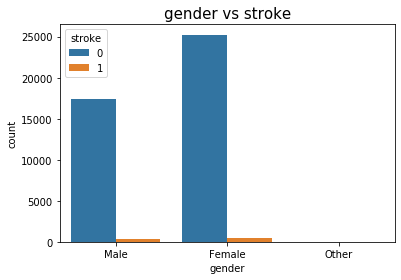

In [13]:
sns.countplot(x=train_data["gender"],hue=train_data["stroke"])
plt.title("gender vs stroke",fontsize=15)
plt.show()

#### Finding the smoking_status count

In [14]:
train_data["smoking_status"].value_counts()

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

#### Grouping the smoking_status based on stroke

In [15]:
train_data.groupby(["smoking_status"])["stroke"].value_counts()

smoking_status   stroke
formerly smoked  0          7272
                 1           221
never smoked     0         15769
                 1           284
smokes           0          6429
                 1           133
Name: stroke, dtype: int64

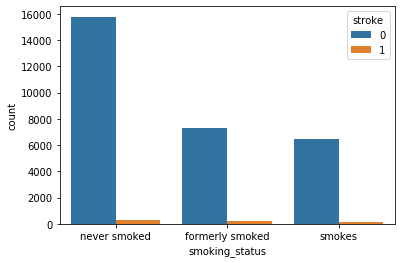

In [16]:
sns.countplot(x=train_data["smoking_status"],hue=train_data["stroke"])
plt.show()

#### Grouping the smoking_status and gender based on stroke

In [17]:
train_data.groupby(["smoking_status",'gender'])["stroke"].value_counts()

smoking_status   gender  stroke
formerly smoked  Female  0          4019
                         1            98
                 Male    0          3247
                         1           123
                 Other   0             6
never smoked     Female  0         10371
                         1           197
                 Male    0          5396
                         1            87
                 Other   0             2
smokes           Female  0          3616
                         1            65
                 Male    0          2812
                         1            68
                 Other   0             1
Name: stroke, dtype: int64

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 7 Text xticklabel objects>)

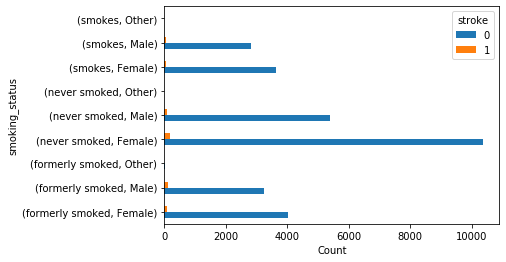

In [18]:
stroke_count = train_data.groupby(["smoking_status",'gender'])["stroke"].value_counts().unstack()
ax = stroke_count.plot(kind='barh')
ax.set_ylabel('smoking_status')
ax.set_xlabel('Count')
plt.xticks(rotation=0)

#### Grouping the smoking_status and work_type based on stroke

In [19]:
train_data.groupby(["smoking_status",'work_type'])["stroke"].value_counts()

smoking_status   work_type      stroke
formerly smoked  Govt_job       0          1067
                                1            24
                 Never_worked   0             9
                 Private        0          4507
                                1           122
                 Self-employed  0          1585
                                1            75
                 children       0           104
never smoked     Govt_job       0          2255
                                1            36
                 Never_worked   0            85
                 Private        0         10298
                                1           154
                 Self-employed  0          2613
                                1            94
                 children       0           518
smokes           Govt_job       0           952
                                1            12
                 Never_worked   0             7
                 Private        0          4416
 

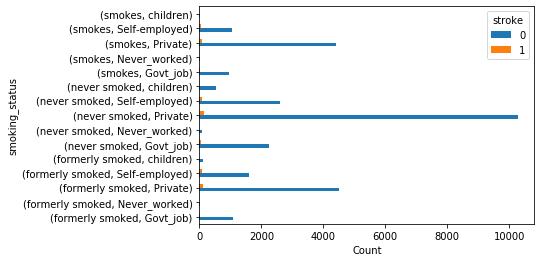

In [20]:
stroke_count = train_data.groupby(["smoking_status",'work_type'])["stroke"].value_counts().unstack()
stroke_count.plot(kind='barh')
plt.ylabel('smoking_status')
plt.xlabel('Count')
plt.xticks(rotation=0)
plt.show()

In [21]:
train_data["age"].astype(int).unique()

array([ 3, 58,  8, 70, 14, 47, 52, 75, 32, 74, 79, 37, 40, 35, 20, 42, 44,
       65, 57, 49, 71, 59, 25, 67, 38, 54, 27, 23, 55, 17, 13,  4, 16, 22,
       45, 66, 69, 53, 78, 43, 51, 30, 46, 61, 48, 29, 11, 76, 21, 18, 33,
       82, 24, 34, 64, 68, 60, 36, 39,  0, 72, 41, 56,  5, 80, 26, 31,  7,
       12, 63, 62,  2, 81,  9, 15, 28, 10, 77,  1, 73, 50, 19,  6],
      dtype=int64)

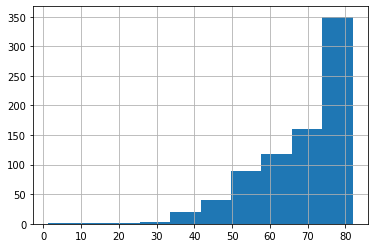

In [22]:
train_data.age[train_data.stroke==1].hist()
plt.show()

#### from the above graph we can observe there is high chance of getting stroke of age category 70-80 

In [23]:
str_data=train_data.select_dtypes(include=['object'])
str_data.columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [24]:
int_data=train_data.select_dtypes(include=['integer',"float"])
int_data.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke'],
      dtype='object')

# LabelEncoder

#### Applying LabelEncoder to convert object into integer

In [25]:
label=LabelEncoder()
train_data['gender'] = label.fit_transform(train_data['gender'])
train_data['ever_married'] = label.fit_transform(train_data['ever_married'])
train_data['work_type']= label.fit_transform(train_data['work_type'])
train_data['Residence_type']= label.fit_transform(train_data['Residence_type'])
features= train_data[train_data['smoking_status'].notnull()]
features['smoking_status']= label.fit_transform(features['smoking_status'])
features.head()

C:\Users\ajayc\Anaconda3\spyder\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,1,0
3,56543,0,70.0,0,0,1,2,0,69.04,35.9,0,0
6,52800,0,52.0,0,0,1,2,1,77.59,17.7,0,0
7,41413,0,75.0,0,1,1,3,0,243.53,27.0,1,0
8,15266,0,32.0,0,0,1,2,0,77.67,32.3,2,0


### Correlation

#### Correlation Used for finding the relation between the variables

In [26]:
corr=features.corr()
corr.nlargest(12,'stroke')["stroke"]

stroke               1.000000
age                  0.159838
heart_disease        0.107007
avg_glucose_level    0.077206
hypertension         0.073310
ever_married         0.051666
work_type            0.025708
gender               0.013689
id                   0.002238
Residence_type       0.002064
smoking_status      -0.023068
bmi                 -0.055692
Name: stroke, dtype: float64

In [27]:
xtrain=features.drop(["stroke","id"],axis=1)
xtrain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1,1,58.0,1,0,1,2,1,87.96,39.2,1
3,0,70.0,0,0,1,2,0,69.04,35.9,0
6,0,52.0,0,0,1,2,1,77.59,17.7,0
7,0,75.0,0,1,1,3,0,243.53,27.0,1
8,0,32.0,0,0,1,2,0,77.67,32.3,2


In [28]:
xtrain.shape

(30108, 10)

In [29]:
ytrain=features["stroke"]
ytrain.shape

(30108,)

#### In both cases we can see we are dealing with imbalanced data set, if we go ahead with that there is a high possibility that it ML algorithm will predict no stroke for all data. So we need to make the data more balanced

In [30]:
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_sample(xtrain, ytrain)
print ('ROS Input Data Shape for Smoke Data: {}'.format(X_res.shape))
print ('ROS Output Data Shape for Smoke Data: {}'.format(y_res.shape))

ROS Input Data Shape for Smoke Data: (58940, 10)
ROS Output Data Shape for Smoke Data: (58940,)


In [31]:
data=pd.Series(y_res)
data.value_counts()

1    29470
0    29470
Name: stroke, dtype: int64

#### split the data into traing and testing

In [32]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.2,random_state=41)
print(x_train.shape)
print(x_test.shape)

(47152, 10)
(11788, 10)


# Building NaiveBayes Model

In [33]:
model=GaussianNB()
model.fit(x_train,y_train)

GaussianNB()

In [34]:
predict=model.predict(x_test)
predict

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [35]:
test_score=model.score(x_test,y_test)
print("NBtest_score:",test_score)

NBtest_score: 0.7318459450288429


In [36]:
train_score=model.score(x_train,y_train)
print("NBtrain_score:",train_score)

NBtrain_score: 0.738102307431286


#### NaiveBayes Confusion Matrix

In [37]:
nb_conf_mtr=pd.crosstab(y_test,predict)
nb_conf_mtr

col_0,0,1
stroke,,
0,4455,1398
1,1763,4172


#### Classification Report for naivebayes

In [38]:
nbreport=classification_report(y_test,predict)
print(nbreport)

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      5853
           1       0.75      0.70      0.73      5935

    accuracy                           0.73     11788
   macro avg       0.73      0.73      0.73     11788
weighted avg       0.73      0.73      0.73     11788



#### Building Decision Tree Model


In [39]:
dt_mod=DecisionTreeClassifier(criterion='entropy',max_depth=23,random_state=3)
dt_mod.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=23, random_state=3)

In [40]:
y_pred=dt_mod.predict(x_test)
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [41]:
ts_dt_score=dt_mod.score(x_test,y_test)
print("DTtest_score:",ts_dt_score)

DTtest_score: 0.9790464879538514


In [42]:
tr_dt_score=dt_mod.score(x_train,y_train)
print("DTtrain_score:",tr_dt_score)

DTtrain_score: 0.9900322361723787


#### DecisionTree Confusion Matrix

In [43]:
dt_conf_mtr=pd.crosstab(y_test,y_pred)
dt_conf_mtr

col_0,0,1
stroke,,
0,5606,247
1,0,5935


#### Classification report for decisiontree

In [44]:
dt_report=classification_report(y_test,y_pred)
print(dt_report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      5853
           1       0.96      1.00      0.98      5935

    accuracy                           0.98     11788
   macro avg       0.98      0.98      0.98     11788
weighted avg       0.98      0.98      0.98     11788



# Building Neural Network


In [45]:
mlp_model=MLPClassifier(activation='relu',hidden_layer_sizes=(20,20),max_iter=1000, 
                        batch_size=10,alpha=0.0001,learning_rate_init=0.001,
                        solver='adam',random_state=4)
mlp_model.fit(x_train,y_train)

MLPClassifier(batch_size=10, hidden_layer_sizes=(20, 20), max_iter=1000,
              random_state=4)

In [46]:
mlp_predict=mlp_model.predict(x_test)
mlp_predict

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [47]:
ts_mlp_score=mlp_model.score(x_test,y_test)
print("NNtest_acore:",ts_mlp_score)

NNtest_acore: 0.8078554462164913


In [48]:
tr_mlp_score=mlp_model.score(x_train,y_train)
print("NNtrain_acore:",tr_mlp_score)

NNtrain_acore: 0.8105064472344757


#### Observing the three model scores Decision tree Classifier performance is having more accuracy.

In [49]:
score=pd.DataFrame({"score":{"nb_score":test_score,
                             "dt_score":ts_dt_score,
                             "nn_score":ts_mlp_score}})
score

,score
dt_score,0.979046
nb_score,0.731846
nn_score,0.807855


#### Feature Importance with decision tree model

In [50]:
index=xtrain.loc[:,xtrain.columns]
index

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1,1,58.0,1,0,1,2,1,87.96,39.2,1
3,0,70.0,0,0,1,2,0,69.04,35.9,0
6,0,52.0,0,0,1,2,1,77.59,17.7,0
7,0,75.0,0,1,1,3,0,243.53,27.0,1
8,0,32.0,0,0,1,2,0,77.67,32.3,2
...,...,...,...,...,...,...,...,...,...,...
43395,0,10.0,0,0,0,4,1,58.64,20.4,1
43396,0,56.0,0,0,1,0,1,213.61,55.4,0
43397,0,82.0,1,0,1,2,1,91.94,28.9,0
43398,1,40.0,0,0,1,2,1,99.16,33.2,1


In [51]:
impFeatures = pd.DataFrame(dt_mod.feature_importances_ ,index=xtrain.columns,
                           columns=['Importance']).sort_values(by='Importance',ascending=False)
print(impFeatures)

                   Importance
age                  0.370541
avg_glucose_level    0.246596
bmi                  0.217385
smoking_status       0.043367
work_type            0.036561
Residence_type       0.023228
hypertension         0.020413
gender               0.015228
heart_disease        0.014949
ever_married         0.011732


#### observing the above output age,id,bmi,avg_gloucose_level and work_type are most important features in prediction

In [52]:
test=pd.read_csv("heart_test.csv")
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [53]:
print ('Test Data Shape: {}'.format(test.shape))

Test Data Shape: (18601, 11)


#### Checking the missing values

In [54]:
test_missing_values=test.isnull().sum()
test_missing_values

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   591
smoking_status       5751
dtype: int64

In [55]:
test_data=test.dropna(axis=0,how="any")
test_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked
5,9348,Female,66.0,1,0,Yes,Private,Urban,219.98,32.2,never smoked
7,60512,Male,46.0,0,0,Yes,Govt_job,Urban,120.80,32.5,never smoked


In [56]:
print ('Test Data Shape: {}'.format(test_data.shape))

Test Data Shape: (12423, 11)


In [57]:
test_data['gender'] = label.fit_transform(test_data['gender'])
test_data['ever_married'] = label.fit_transform(test_data['ever_married'])
test_data['work_type']= label.fit_transform(test_data['work_type'])
test_data['Residence_type']= label.fit_transform(test_data['Residence_type'])


C:\Users\ajayc\Anaconda3\spyder\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ajayc\Anaconda3\spyder\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ajayc\Anaconda3\spyder\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [58]:
test= test_data[test_data['smoking_status'].notnull()]
test['smoking_status']= label.fit_transform(test['smoking_status'])
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,1,80.0,0,0,1,2,1,83.84,21.1,0
1,61829,0,74.0,0,1,1,3,0,179.50,26.0,0
4,40801,0,63.0,0,0,1,0,0,83.57,27.6,1
5,9348,0,66.0,1,0,1,2,1,219.98,32.2,1
7,60512,1,46.0,0,0,1,0,1,120.80,32.5,1


In [59]:
test=test.drop(["id"],axis=1)

In [60]:
dtt_prd=dt_mod.predict(test)
dtt_prd

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [61]:
test["prediction"]=dtt_prd
test.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,prediction
0,1,80.0,0,0,1,2,1,83.84,21.1,0,0
1,0,74.0,0,1,1,3,0,179.50,26.0,0,0
4,0,63.0,0,0,1,0,0,83.57,27.6,1,0
5,0,66.0,1,0,1,2,1,219.98,32.2,1,0
7,1,46.0,0,0,1,0,1,120.80,32.5,1,0


In [62]:
test["prediction"].value_counts()

0    11892
1      531
Name: prediction, dtype: int64

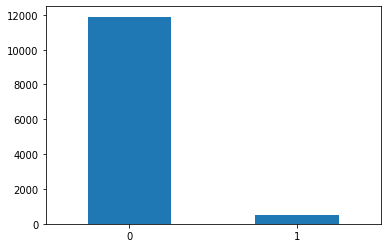

In [63]:
test["prediction"].value_counts().plot(kind="bar")
plt.xticks(rotation=0)
plt.show()

In [64]:
no_stroke=test[test["prediction"]==0]
no_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,prediction
0,1,80.0,0,0,1,2,1,83.84,21.1,0,0
1,0,74.0,0,1,1,3,0,179.50,26.0,0,0
4,0,63.0,0,0,1,0,0,83.57,27.6,1,0
5,0,66.0,1,0,1,2,1,219.98,32.2,1,0
7,1,46.0,0,0,1,0,1,120.80,32.5,1,0


In [65]:
stroke=test[test["prediction"]==1]
stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,prediction
8,0,75.0,0,0,1,3,0,78.71,28.0,1,1
14,0,67.0,0,0,1,0,1,236.60,24.2,1,1
43,1,51.0,0,0,1,2,1,192.53,33.7,0,1
49,0,71.0,0,0,1,0,1,173.02,29.2,0,1
96,0,53.0,0,0,1,2,1,203.19,35.9,1,1
